In [1]:
from siuba import *
from siuba.sql import LazyTbl
from siuba.dply import vector as vec
from siuba.dply.vector import n

from plotnine import *

from sqlalchemy import create_engine

# TODO: once calitp package is up, should be able to use
# that to get the relevant tables
%run ../_gtfs_schedule_views/ipynb/_setup.ipynb

tbl = AutoTable(
    engine,
    lambda s: s.replace(".", "_").replace("test_", ""),
    lambda s: "test_" not in s and "__staging" not in s
)

## Grab specific agency feeds

In [2]:
DATE_START="2021-04-16"
DATE_END="2021-05-16"

THE_FUTURE="2099-01-01"


EXAMPLE_AGENCY_NAMES = [
    "Tahoe Truckee Area Regional Transportation",
    "Metro",
    "Monterey-Salinas Transit",
    "Fairfield and Suisun Transit",
    "AC Transit",
    "Big Blue Bus"
]

In [3]:
tbl_feeds = (
    tbl.gtfs_schedule_calitp_status()
    >> select(
        _.calitp_itp_id == _.itp_id, _.calitp_url_number == _.url_number, _.agency_name
    )
    >> filter(_.agency_name.isin(EXAMPLE_AGENCY_NAMES))

    >> mutate(agency_name = _.agency_name + " (" + _.calitp_url_number.astype(str) + ")")
)

# will be used to limit the number of feeds shown in data
join_feeds = inner_join(_, tbl_feeds, ["calitp_itp_id", "calitp_url_number"])

tbl_feeds

,calitp_itp_id,calitp_url_number,agency_name
0,0,0,Big Blue Bus (0)
1,1,1,Fairfield and Suisun Transit (1)
2,1,2,Fairfield and Suisun Transit (2)
3,4,0,AC Transit (0)
4,8,1,Monterey-Salinas Transit (1)


In [4]:
def query_id_changes(start_table, end_table, id_vars, agg=False):
    sym_id_vars = [_[k] for k in id_vars]

    is_in_start = start_table >> select(*id_vars) >> mutate(is_in_start=True)
    is_in_end = end_table >> select(*id_vars) >> mutate(is_in_end=True)

    tallies = (
        is_in_start
        >> full_join(_, is_in_end, id_vars)
        >> count(*sym_id_vars, _.is_in_start, _.is_in_end)
        >> mutate(
            status=case_when(
                _,
                {
                    _.is_in_end.isna(): "Removed",
                    _.is_in_start.isna(): "Added",
                    True: "Unchanged",
                },
            )
        )
    )
    
    if agg:
        return tallies >> count(*sym_id_vars[:-1], _.status)
    
    return tallies

def fetch_date(table, date, future_date = THE_FUTURE):
    return table >> filter(_.calitp_extracted_at <= date, _.calitp_deleted_at.fillna(future_date) > date)

## Route id changes

In [5]:
routes_start = (tbl.gtfs_schedule_type2_routes()
    >> filter(_.calitp_extracted_at <= DATE_START, _.calitp_deleted_at.fillna(THE_FUTURE) > DATE_START)
)

routes_end = (tbl.gtfs_schedule_type2_routes()
    >> filter(_.calitp_extracted_at <= DATE_END, _.calitp_deleted_at.fillna(THE_FUTURE) > DATE_END)
)

In [6]:
keep_keys = ("calitp_itp_id", "calitp_url_number", "route_id")

route_id_changes = (
    routes_start
    >> select(*keep_keys)
    >> mutate(is_in_start=True)
    >> full_join(
        _, routes_end >> select(*keep_keys) >> mutate(is_in_end=True), keep_keys
    )
    >> count(_.calitp_itp_id, _.calitp_url_number, _.is_in_start, _.is_in_end)
    >> mutate(
        status=case_when(
            _,
            {
                _.is_in_end.isna(): "Removed",
                _.is_in_start.isna(): "Added",
                True: "Unchanged",                
            },
        )
    )
)

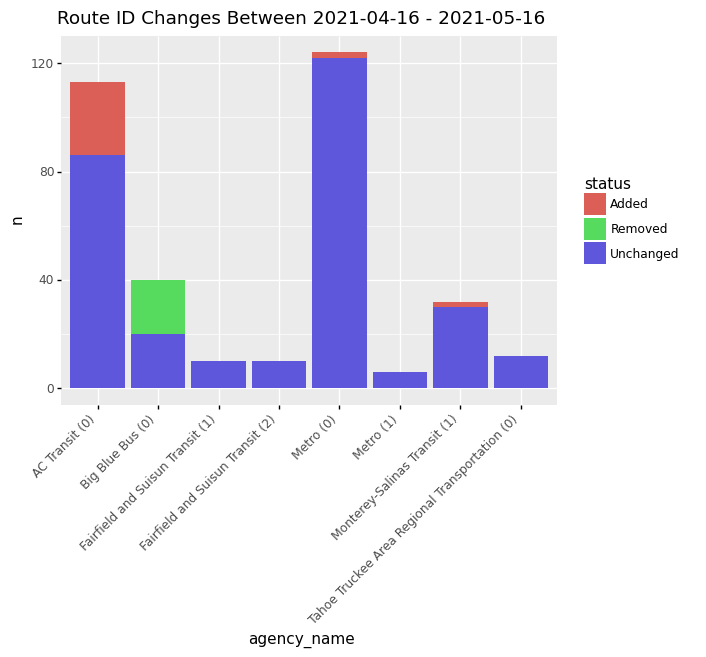

<ggplot: (-9223372036529127052)>

In [7]:
(
    route_id_changes
    >> join_feeds
    >> collect()
    >> ggplot(aes("agency_name", "n", fill="status"))
    + geom_col()
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + labs(title = "Route ID Changes Between %s - %s"% (DATE_START, DATE_END))
)

## Trip ID changes

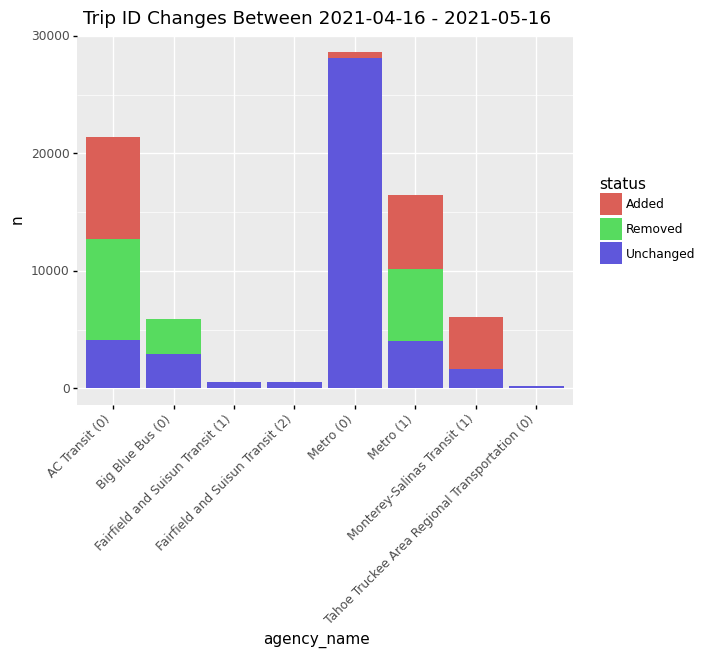

<ggplot: (-9223372036529115595)>

In [8]:
trips_start = fetch_date(tbl.gtfs_schedule_type2_trips(), DATE_START)
trips_end = fetch_date(tbl.gtfs_schedule_type2_trips(), DATE_END)

(
    query_id_changes(
        trips_start,
        trips_end,
        ["calitp_itp_id", "calitp_url_number", "trip_id"],
        agg=True,
    )
    >> join_feeds
    >> collect()
    >> ggplot(aes("agency_name", "n", fill="status"))
    + geom_col()
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + labs(title = "Trip ID Changes Between %s - %s"% (DATE_START, DATE_END))
    
)

## Stop ID changes

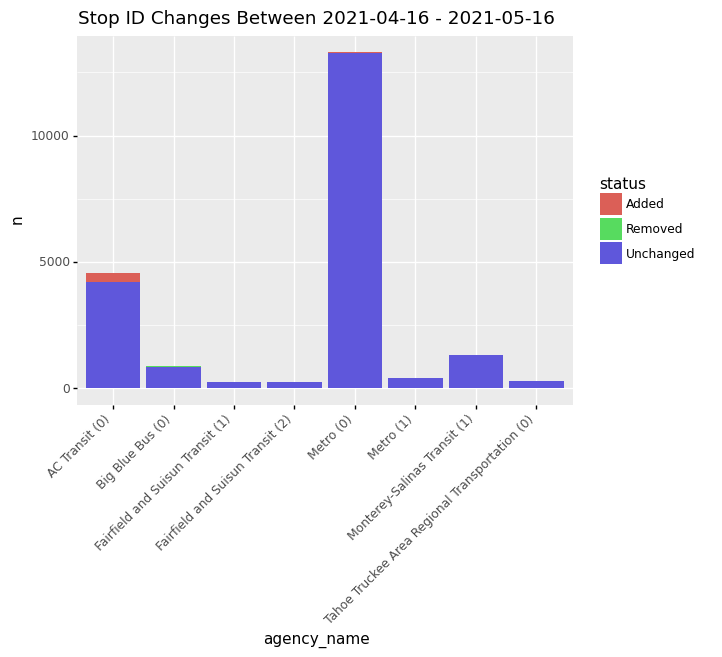

<ggplot: (326454227)>

In [9]:
stops_start = fetch_date(tbl.gtfs_schedule_type2_stops(), DATE_START)
stops_end = fetch_date(tbl.gtfs_schedule_type2_stops(), DATE_END)

(
    query_id_changes(
        stops_start,
        stops_end,
        ["calitp_itp_id", "calitp_url_number", "stop_id"],
        agg=True,
    )
    >> join_feeds
    >> collect()
    >> ggplot(aes("agency_name", "n", fill="status"))
    + geom_col()
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + labs(title = "Stop ID Changes Between %s - %s"% (DATE_START, DATE_END))
    
)